## Description
+ DATA Flow:

  We take one example at a time for forward feed and update parameters(weights)
  only if prediction is wrong


+ MODEL Architecture:

  It has a Weight matrix of size 6x10x784
  We perform Matrix - Vector multiplication i.e. W 10x784 with X 784(data/example)
  
  for six slices of our weight matrix , followed by adding the result of each slice 
  for each class respectively
  
  Alternate Dropout for Weight matrix slices is used
  
  Accuracy is tested for data which model has not seen

### Some extras
 - Weights Matrix slices for each digit can be visualized after training by calling
     weights_trained()
 - Accuracy can also be tested by calling
     acc_test

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
np.random.seed(101)  # Randomness Ceased for Coding Purpose

### Training Data Preprocessing 

In [2]:
# Importing Training Data
df = pd.read_csv("mnist_train.csv")

In [3]:
# Separating Labels and Features
x = np.array(df.loc[:, df.columns != 'Label'])
x_data = x.transpose()
# x_data.shape   >>> (784, 60000)
y = np.array(df.loc[:, df.columns == 'Label'])
# y.shape        >>> (60000, 1)

In [4]:
# One hot Encoding
y_label = np.zeros((10,60000),np.float32)
for i in range(60000):
    for j in range(10):
        if y[i,0] == j:
            y_label[j,i] = int(1)

In [5]:
# Scaling Data
scale = MinMaxScaler()
x_data_Scaled = scale.fit_transform(x_data)

C:\Users\Sameer\Anaconda3\envs\Tensor\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


### Test Data Preprocessing

In [6]:
# Importing Training Data
df = pd.read_csv("mnist_test.csv")

In [7]:
# Separating Labels and Features
x_test = np.array(df.loc[:, df.columns != 'Label'])
x_test = x_test.transpose()
#x_test.shape   >>> (784, 10000)
y_test = np.array(df.loc[:, df.columns == 'Label'])
#y_test.shape   >>> (10000, 1)

In [8]:
# One hot Encoding
y_label_test = np.zeros((10,10000),np.float32)
for i in range(10000):
    for j in range(10):
        if y_test[i,0] == j:
            y_label_test[j,i] = int(1)

In [9]:
# Scaling Data
x_test_Scaled = scale.fit_transform(x_test)

C:\Users\Sameer\Anaconda3\envs\Tensor\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


### Finished preprocessing



## Model

In [10]:
np.random.seed(101)  # Randomness Ceased for Coding Purpose
#w = np.ones((6,10,784))*1.0  #For weight templates with less noise
w = np.random.random((6,10,784)) + 0.0005    # Randomly Initializing Weights
w[0,:,:] = w[0,:,:]*(-1)
w[1,:,:] = w[1,:,:]*(-1)
b = np.ones(10)      # Bias set to 1 for each class
_LOSS_ = []                 # List to record Loss
epochs = 40000        #int(input("Enter number of epochs: "))

In [11]:
# Provides prediction for nth example
def predict(n):
    #det = np.sum(det,axis=1,keepdims=True)
    p_hat = np.ones((10,6))  # Temporary 2D Predicted Score Matrix
    for bx in range(6):
        p_hat[:,bx] = np.matmul(w[bx,:,:],x_test_Scaled[:,n]) + b  #Operating on nth index example for a slice of weight matrix
    p_hat = np.sum(p_hat,axis=1)      # Generating a 1D Predicted Score Matrix
    p_predict = np.argmax(p_hat)      # Grabbing Predicted Number (index)
    p_true = np.argmax(y_label_test[:,n])  # Grabbing True Number (index)
    return p_predict , p_true

In [12]:
def acc_test():
    k=0
    for i in range (10000):
        p1 , p2 = predict(i)
        if p1==p2:
            k=k+1
    print("Accuracy is now ","%0.2f"%(100*(k/10000)),'%') #Currently set for Entire Data Set of Test i.e. 10000
    return 100*(k/10000)

In [13]:
# Calculates Loss
def softmax_Loss(y_hat,y,w):
    #y_hat = y_hat/((np.matmul(y_hat,y_hat))**0.5) # Just making Unit Vectors (to be verified)
    y_hat = y_hat/np.max(y_hat)  # >.< Sudo normalization
    y_hat = np.exp(y_hat)        #
    j = np.argmax(y)
    loss = -np.log(y_hat[j]/(np.sum(y_hat)))
    
    return loss , j , np.sum(y_hat)

In [14]:
# Function to update Weights 
def parameter_update(w,j,x,s,p_la,ep):
    l_rate = 0.001 #Learning Rate if 0.0005?
    if(j!=p_la):  # Due to this if-else updation happens iff prediction is wrong
        if(ep%2==0):  # Alternate slice of weight matrix updated
            ls = [0,2,4]                           #ls is just an identifier
            for be in ls:
                for i in range(784):  
                    w[be,j,i] -= l_rate*(-x[i]+((x[i]*np.exp(w[be,j,i]))/s))
        else:
            ls = [1,3,5]
            for be in ls:
                for i in range(784):  
                    w[be,j,i] -= l_rate*(-x[i]+((x[i]*np.exp(w[be,j,i]))/s))
        ep += 1 # For alternate dropout 
    return w , ep

In [15]:
#In this Block all model layers and functions are called
y_hat = np.random.random((10,6))
acc_list = []
ep_count = 0
count = 0  #related to ep identifier in param..update fn
for i in range(epochs):
    x = x_data_Scaled[:,i]  # Took ith sample
    y = y_label[:,i]        # Took true label column of ith sample
    for new in range(6):
        y_hat[:,new] = np.matmul(w[new,:,:],x) #+ b    # Operation
    score = np.sum(y_hat,axis=1)
    loss , j , s = softmax_Loss(score,y,w)  # Function Call to calculate Loss
    _LOSS_.append(loss)

    w , count= parameter_update(w,j,x,s,np.argmax(score),count)  
    if(i%200==0):
        print("Epoch count = "+str(i))
        al = acc_test()
        acc_list.append(al)
        ep_count += 1

Epoch count = 0
Accuracy is now  6.30 %
Epoch count = 200
Accuracy is now  7.07 %
Epoch count = 400
Accuracy is now  7.99 %
Epoch count = 600
Accuracy is now  9.10 %
Epoch count = 800
Accuracy is now  10.61 %
Epoch count = 1000
Accuracy is now  11.98 %
Epoch count = 1200
Accuracy is now  14.15 %
Epoch count = 1400
Accuracy is now  16.53 %
Epoch count = 1600
Accuracy is now  18.69 %
Epoch count = 1800
Accuracy is now  21.93 %
Epoch count = 2000
Accuracy is now  24.54 %
Epoch count = 2200
Accuracy is now  27.31 %
Epoch count = 2400
Accuracy is now  29.59 %
Epoch count = 2600
Accuracy is now  31.93 %
Epoch count = 2800
Accuracy is now  33.97 %
Epoch count = 3000
Accuracy is now  35.98 %
Epoch count = 3200
Accuracy is now  39.19 %
Epoch count = 3400
Accuracy is now  40.60 %
Epoch count = 3600
Accuracy is now  42.56 %
Epoch count = 3800
Accuracy is now  43.97 %
Epoch count = 4000
Accuracy is now  45.08 %
Epoch count = 4200
Accuracy is now  46.52 %
Epoch count = 4400
Accuracy is now  48.03 %

Accuracy is now  80.57 %
Epoch count = 36800
Accuracy is now  80.78 %
Epoch count = 37000
Accuracy is now  80.85 %
Epoch count = 37200
Accuracy is now  80.91 %
Epoch count = 37400
Accuracy is now  80.74 %
Epoch count = 37600
Accuracy is now  80.65 %
Epoch count = 37800
Accuracy is now  80.44 %
Epoch count = 38000
Accuracy is now  80.72 %
Epoch count = 38200
Accuracy is now  81.01 %
Epoch count = 38400
Accuracy is now  81.04 %
Epoch count = 38600
Accuracy is now  81.17 %
Epoch count = 38800
Accuracy is now  81.09 %
Epoch count = 39000
Accuracy is now  80.96 %
Epoch count = 39200
Accuracy is now  80.87 %
Epoch count = 39400
Accuracy is now  80.93 %
Epoch count = 39600
Accuracy is now  81.20 %
Epoch count = 39800
Accuracy is now  81.43 %


Training Complete

## Visualization  (Extras)

In [16]:
#Plotting of Loss was not of Great help
#plt.plot(list(range(epochs)),_LOSS_)

Text(0,0.5,'Accuracy')

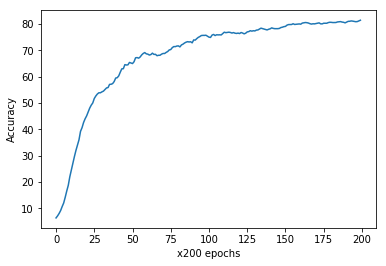

In [17]:
plt.plot(list(range(ep_count)),acc_list)
plt.xlabel("x200 epochs")
plt.ylabel("Accuracy")

In [18]:
# To visualize Template of each Number
def weights_trained():
    no = int(input("Enter a digit 0-9: "))
    sli = int(input("Enter a slice 0-5: "))
    plt.imshow(w[sli,no,:].reshape(28,28),cmap='gray')

Enter a digit 0-9: 8
Enter a slice 0-5: 2


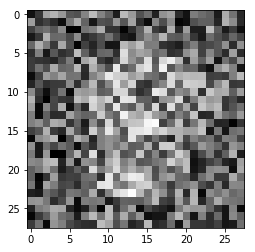

In [19]:
#Learned weights after training (one slice is displayed at a time REMEMBER w.shape is 10x784x6)
weights_trained()   

In [20]:
#Weight matrix can be made clearer by initializing weights as ones

In [21]:
#Following function expects a 1D or 2D matrix
#np.savetxt("trained weights.csv",w,delimiter=',')